# DnCNN_V1

Implementing the "Beyond Gaussian Denoising" Neural Network.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import datetime

## Data Preprocessing

I will start by loading two of the images in. Then I will select from the originals each only one. Aftwards, I will select the 500 images in good and bad quality from the two image and create the classification label for it.

In [3]:
select = np.random.choice(np.arange(0, 4055), size = 100)

In [4]:
X_1 = np.load('/home/cloud/MRT_Data/unziped/out/P2_X.npy')

X_2 = np.load('/home/cloud/MRT_Data/unziped/out/P11_X.npy')

X_3 = np.load('/home/cloud/MRT_Data/unziped/out/P6_X.npy')

X = np.concatenate(seq = (X_1, X_2), axis=0)

X.shape

del X_1, X_2

In [5]:
X = X_1

In [6]:
X = X.reshape([4055, 256, 256, 1])

In [7]:
X = X[select, :, :]

In [8]:
del X_1

In [9]:
gc.collect()

14

 Normalize data

In [10]:
Y_1 = np.load('/home/cloud/MRT_Data/unziped/out/P2_Y.npy')

Y_2 = np.load('/home/cloud/MRT_Data/unziped/out/P11_Y.npy')

Y_3 = np.load('/home/cloud/MRT_Data/unziped/out/P6_Y.npy')

Y = np.concatenate(seq = (Y_1, Y_2), axis=0)

Y.shape

del Y_1, Y_2

In [11]:
Y = Y_1

In [12]:
Y = Y.reshape([4055, 256, 256, 1])

In [13]:
Y.shape

(4055, 256, 256, 1)

In [14]:
Y = Y[select, :, :]

clean up the mess

In [15]:
gc.collect()

3

In [16]:
Y.shape

(100, 256, 256, 1)

# Create train and test and validation set

In [17]:
train_frac = 0.9

In [18]:
train_index = int(train_frac * Y.shape[0])

In [19]:
X_train = X[0:train_index,:,:,:]
X_eval = X[train_index:X.shape[0],:,:,:]

In [20]:
Y_train = Y[0:train_index,:,:]
Y_eval = Y[train_index:X.shape[0],:,:,:]

In [111]:
def conv_layer(tensor_in, name_layer, is_training):
    x = tf.layers.conv2d(
        inputs = tensor_in,
        filters = 64,
        kernel_size = [3, 3],
        padding = "same",
        activation= None,
        name = name_layer)
    if(is_training):
        x = tf.layers.batch_normalization(x, name = name_layer + "_bn",
                                             center=True, 
                                             scale=True, 
                                             training=is_training)
    
    return tf.nn.relu(x, name = name_layer + "_relu")

# Create and train CNN

In [112]:
def cnn_model_fn(features, labels, mode):
    
    ## Hyper paramters ##
    eps_start = 0.04 #learning rate in the beginning
    eps_end = eps_start / 100 #final learning rate
    tau = 10000 # number of iterations afterwards is the learning rate constant
    #####################
    
    # Input Layer
    input_layer = features['x']
    
    # Convolutional layer #1     
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 64,
        kernel_size = 3,
        padding = "same",
        activation= tf.nn.relu,
        name = "Conv_1")
    is_training_mode = (mode == tf.estimator.ModeKeys.TRAIN)
    
     # 18 of the middle layers with Convolution, batch normalization and afterwards ReLu
    conv2 = conv_layer(conv1, "conv2", is_training = is_training_mode)
    conv3 = conv_layer(conv2, "conv3", is_training = is_training_mode)
    conv4 = conv_layer(conv3, "conv4", is_training = is_training_mode)
    conv5 = conv_layer(conv4, "conv5", is_training = is_training_mode)
    conv6 = conv_layer(conv5, "conv6", is_training = is_training_mode)
    conv7 = conv_layer(conv6, "conv7", is_training = is_training_mode)
    conv8 = conv_layer(conv7, "conv8", is_training = is_training_mode)
    conv9 = conv_layer(conv8, "conv9", is_training = is_training_mode)
    conv10 = conv_layer(conv9, "conv10", is_training = is_training_mode)
    conv11 = conv_layer(conv10, "conv11", is_training = is_training_mode)
    conv12 = conv_layer(conv11, "conv12", is_training = is_training_mode)
    conv13 = conv_layer(conv12, "conv13", is_training = is_training_mode)
    conv14 = conv_layer(conv13, "conv14", is_training = is_training_mode)
    conv15 = conv_layer(conv14, "conv15", is_training = is_training_mode)
    conv16 = conv_layer(conv15, "conv16", is_training = is_training_mode)
    conv17 = conv_layer(conv16, "conv17", is_training = is_training_mode)
    conv18 = conv_layer(conv17, "conv18", is_training = is_training_mode)
    conv19 = conv_layer(conv18, "conv19", is_training = is_training_mode)

    # final 
    final_layer = tf.layers.conv2d(
        inputs = conv19,
        filters = 1,
        kernel_size = [1, 1],
        padding = "same",
        activation = None,
        name = "final_layer") + input_layer
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions=final_layer)
    
    # Calculate Loss (for both Train and EVAL modes)
    # See that the residual learning is implemented here.
    loss = tf.losses.mean_squared_error(labels = labels , predictions = final_layer)
    tf.summary.scalar("Value_Loss_Function", loss)
        
    # Configure the Training OP (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        # calculate current learning rate:
        alpha = tf.train.get_global_step() / tau
        cur_learning_rate = tf.maximum(tf.constant(0.0, dtype ='float64'),(1-alpha)) * eps_start + tf.minimum(tf.constant(1.0, dtype ='float64') , alpha) * eps_end
        tf.summary.scalar("Learning_rate", cur_learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate = cur_learning_rate)
        train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
        
        
    # Output all learnable variables for tensorboard
    for var in tf.trainable_variables():
        name = var.name
        name = name.replace(':', '_')
        tf.summary.histogram(name, var)
    merged_summary = tf.summary.merge_all()
    
    # Add evaluation metrics
    eval_metric_ops = {
        "accuracy": tf.metrics.mean_squared_error(
            labels=labels, predictions=final_layer)}
    return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)    


Load train and test data

In [24]:
train_data = X_train
train_labels = Y_train
eval_data = X_eval
eval_labels = Y_eval

Create the estimator

In [25]:
runconf = tf.estimator.RunConfig(save_summary_steps=5, log_step_count_steps = 1)

In [26]:
save_dir = "/tmp/tmp_nets/" + str(datetime.datetime.now())[0:19].replace("-", "_").replace(" ", "_").replace(":", "_").replace(".", "_")

In [113]:
ImpNet = tf.estimator.Estimator(config=runconf,
    model_fn=cnn_model_fn, model_dir='/scratch2/ttoebro/models/2018_12_05_08_05_06'
    )

INFO:tensorflow:Using config: {'_model_dir': '/scratch2/ttoebro/models/2018_12_05_08_05_06', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdf6c30c6d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=10)

logging_hook = tf.train.SummarySaverHook(
     save_steps= 1,
    output_dir="/home/cloud/Training/summary_hook", 
    scaffold=tf.train.Scaffold(summary_op=tf.summary.merge_all())) 

Train the model

In [28]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=Y_train,
    batch_size=32,
    num_epochs=None,
    shuffle=True)

In [ ]:
ImpNet.train(
    input_fn=train_input_fn,
    steps=3)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_nets/2018_12_03_15_36_27/model.ckpt.
INFO:tensorflow:loss = 0.64208615, step = 1
INFO:tensorflow:global_step/sec: 0.0125436
INFO:tensorflow:loss = 0.057684973, step = 2 (79.736 sec)


In [ ]:
tf.__version

## Evaluate the model

Make predictions

This is what we train for (our label)

In [ ]:
plt.imshow(Y_eval[1,:,:,0], cmap='gray' )

This is the input of the NN (The noisy image)

In [ ]:
plt.imshow(X_eval[1,:,:,0], cmap='gray' )

This is the true image, can be calculated as the difference of X to the label we train on

In [ ]:
plt.imshow(X_eval[1,:,:,0] - Y_eval[1,:,:,0] , cmap='gray' )

In [139]:
X_train[0,:,:,0]

array([[0.03529412, 0.02745098, 0.03137255, ..., 0.02745098, 0.02745098,
        0.03529412],
       [0.03529412, 0.03137255, 0.03529412, ..., 0.02352941, 0.02352941,
        0.03921569],
       [0.02745098, 0.03529412, 0.03529412, ..., 0.02352941, 0.02352941,
        0.03529412],
       ...,
       [0.04705882, 0.04705882, 0.03137255, ..., 0.03529412, 0.02745098,
        0.04313726],
       [0.04313726, 0.05490196, 0.03921569, ..., 0.03137255, 0.03529412,
        0.05490196],
       [0.03921569, 0.04705882, 0.03921569, ..., 0.03137255, 0.03921569,
        0.0627451 ]], dtype=float32)

In [140]:
X_eval[0,:,:,0]

array([[0.04705882, 0.03529412, 0.01960784, ..., 0.04313726, 0.03529412,
        0.04313726],
       [0.04705882, 0.03529412, 0.02745098, ..., 0.04313726, 0.02352941,
        0.04705882],
       [0.04705882, 0.03529412, 0.03137255, ..., 0.03529412, 0.02352941,
        0.05490196],
       ...,
       [0.03921569, 0.03137255, 0.03921569, ..., 0.03137255, 0.03921569,
        0.05490196],
       [0.03529412, 0.02745098, 0.03921569, ..., 0.03137255, 0.03529412,
        0.05098039],
       [0.03921569, 0.02745098, 0.03921569, ..., 0.02352941, 0.03137255,
        0.04705882]], dtype=float32)

This is an original image. What does our network predict?

In [114]:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_eval[:,:,:,:]},
    y=X_eval[:,:,:,:],
    num_epochs=1,
    shuffle=False)
predict_results = ImpNet.predict(input_fn=predict_input_fn)
predict_results = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch2/ttoebro/models/2018_12_05_08_05_06/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


The first dictionary is the image shown above. Although I cannot see much in the picture the network is 99.8% sure that it is original!

In [95]:
X_eval[1,:,:,0].shape

(256, 256)

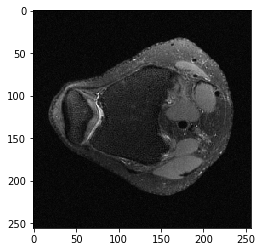

In [96]:
plt.imshow(Y_eval[8,:,:,0], cmap='gray')

In [100]:
X_eval[8,:,:,0]

array([[0.05098039, 0.05098039, 0.04705882, ..., 0.04705882, 0.04313726,
        0.03921569],
       [0.05490196, 0.04705882, 0.04313726, ..., 0.02745098, 0.02745098,
        0.02352941],
       [0.0627451 , 0.05490196, 0.05098039, ..., 0.03137255, 0.02745098,
        0.02745098],
       ...,
       [0.03921569, 0.04705882, 0.05490196, ..., 0.03529412, 0.04705882,
        0.04313726],
       [0.04313726, 0.04313726, 0.03921569, ..., 0.03529412, 0.03921569,
        0.04705882],
       [0.06666667, 0.05490196, 0.03529412, ..., 0.05098039, 0.05098039,
        0.0627451 ]], dtype=float32)

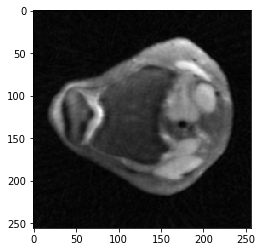

In [89]:
plt.imshow(X_eval[8,:,:,0], cmap='gray')

In [107]:
predict_results[1].shape

(256, 256, 1)

In [128]:
predict_results[2].shape

(256, 256, 1)

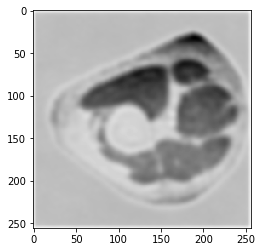

In [133]:
plt.imshow((predict_results[3][:,:,0]), cmap='gray')